In [2]:
!pip install caer canaro

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 809.5/809.5 kB 15.1 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 93.9 MB/s eta 0:00:00:00:0100:01


In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import caer
import gc
import os
import canaro

In [4]:
IMG_SIZE= (80,80)
channels= 1
char_path="/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset"

In [154]:
char_dict=dict()
count=0
for i in os.listdir(char_path):
    char_dict[i]=len(os.listdir(os.path.join(char_path,i)))
    count+=1
    if count==10:
        break
#sorted_dict = dict(sorted(char_dict.items(), key=lambda item: item[1],reverse=True))
char_dict=caer.sort_dict(char_dict,descending=True)

In [155]:
char_dict

[('krusty_the_clown', 1206),
 ('waylon_smithers', 181),
 ('maggie_simpson', 128),
 ('barney_gumble', 106),
 ('ralph_wiggum', 89),
 ('martin_prince', 71),
 ('professor_john_frink', 65),
 ('rainier_wolfcastle', 45),
 ('otto_mann', 32),
 ('fat_tony', 27)]

In [153]:
characters=[]
for i in char_dict:
    characters.append(i[0])

In [26]:
train=caer.preprocess_from_dir(char_path,characters,channels=channels,IMG_SIZE=IMG_SIZE,isShuffle=True)

[INFO] Could not find a file to load from. Generating the training data
----------------------------------------------
[INFO] At 1000 files
[INFO] 1206 files found in 0.04649639129638672s
[INFO] 181 files found in 0.0010466575622558594s
[INFO] 128 files found in 0.0011739730834960938s
[INFO] 106 files found in 0.0011446475982666016s
[INFO] 89 files found in 0.0010149478912353516s
[INFO] 71 files found in 0.00101470947265625s
[INFO] 65 files found in 0.0009932518005371094s
[INFO] 45 files found in 0.0008196830749511719s
[INFO] 32 files found in 0.0007517337799072266s
[INFO] 27 files found in 0.0007987022399902344s
----------------------------------------------
[INFO] 1950 files preprocessed! Took 0m 11s


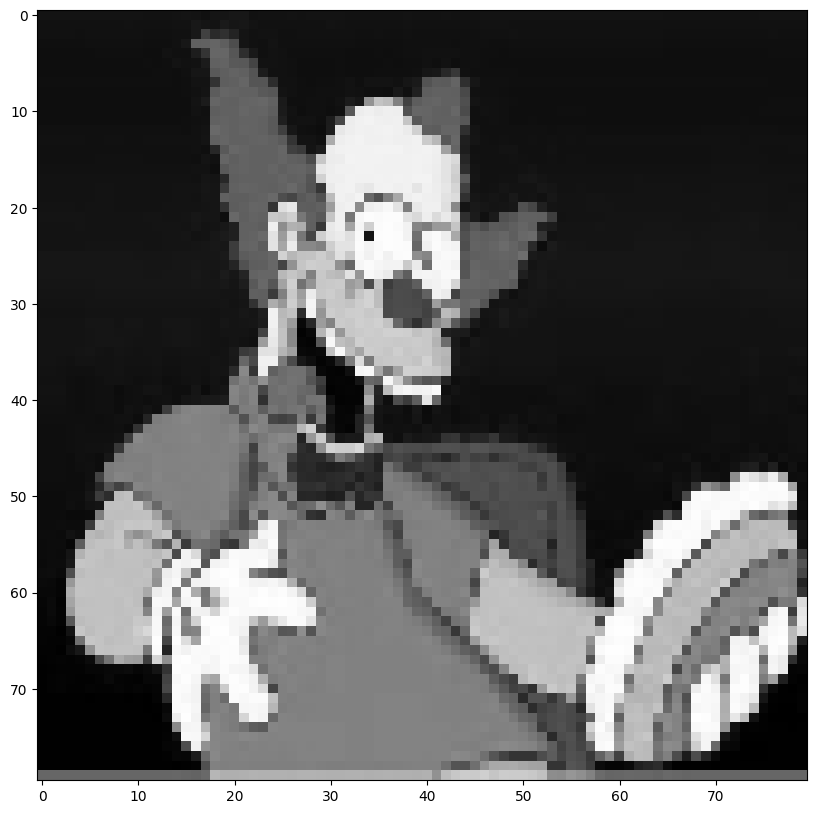

In [31]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.imshow(train[0][0],cmap="gray")
plt.show()

In [34]:
featureset,labels=caer.sep_train(train,IMG_SIZE=IMG_SIZE)

In [46]:
len(labels),len(featureset)

(1950, 1950)

In [48]:
from tensorflow.keras.utils import to_categorical
featureset=caer.normalize(featureset)
labels=to_categorical(labels,len(characters))

In [50]:
x_train,x_test,y_train,y_test=caer.train_val_split(featureset,labels,val_ratio=0.2)

In [51]:
del train
del featureset
del labels
gc.collect()

1118

In [114]:
BATCH_SIZE=32
EPOCHS=100

In [115]:
datagen=canaro.generators.imageDataGenerator()
train_gen=datagen.flow(x_train,y_train,batch_size=BATCH_SIZE)

In [139]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

learning_rate=0.001
w, h = IMG_SIZE[:2]
output_dim=len(characters)
loss="binary_crossentrophy"

model = Sequential()
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

learning_rate=0.001
w, h = IMG_SIZE[:2]
output_dim=len(characters)
loss="binary_crossentropy"

model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(w, h, channels)))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(Conv2D(256, (3, 3), activation='relu'))
model.add(BatchNormalization())  # Add batch normalization layer
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.2))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1024, activation='relu'))

# Output Layer
model.add(Dense(output_dim, activation='softmax'))

#optimizer = SGD(learning_rate=learning_rate, decay=decay, momentum=momentum, nesterov=nesterov)
optimizer = Adam(learning_rate=learning_rate)

model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

In [140]:
model.summary()

Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_144 (Conv2D)             │ (None, 80, 80, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 80, 80, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_145 (Conv2D)             │ (None, 78, 78, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 78, 78, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_72 (MaxPooling2D) │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_96 (Dropout)            │ (None, 39, 39, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_146 (Conv2D)             │ (None, 39, 39, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 39, 39, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_147 (Conv2D)             │ (None, 37, 37, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 37, 37, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_73 (MaxPooling2D) │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_97 (Dropout)            │ (None, 18, 18, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_148 (Conv2D)             │ (None, 18, 18, 256)    │       147,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_149 (Conv2D)             │ (None, 16, 16, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_74 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_98 (Dropout)            │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_24 (Flatten)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_99 (Dropout)            │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1024)           │    16,778,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 10)             │        10,25

 Total params: 17,594,090 (67.12 MB)

 Trainable params: 17,592,682 (67.11 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [141]:
from tensorflow.keras.callbacks import LearningRateScheduler,EarlyStopping

callbacks_list = [
    LearningRateScheduler(canaro.lr_schedule),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

In [142]:
"""
history=model.fit(train_gen,steps_per_epoch=len(x_train)//BATCH_SIZE,
                 epochs=EPOCHS,
                 validation_data=(x_test,y_test),
                 validation_steps=len(y_test)//BATCH_SIZE,
                 callbacks=callbacks_list)
"""
history = model.fit(train_gen,
                    epochs=EPOCHS,
                    validation_data=(x_test, y_test))

Epoch 1/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 21s 198ms/step - accuracy: 0.4907 - loss: 2.1798 - val_accuracy: 0.6547 - val_loss: 0.6023
Epoch 2/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5484 - loss: 0.4400 - val_accuracy: 0.6547 - val_loss: 0.4081
Epoch 3/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5790 - loss: 0.3276 - val_accuracy: 0.6547 - val_loss: 0.2694
Epoch 4/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6037 - loss: 0.2743 - val_accuracy: 0.0870 - val_loss: 0.3843
Epoch 5/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6561 - loss: 0.1948 - val_accuracy: 0.0435 - val_loss: 2.8492
Epoch 6/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6886 - loss: 0.1817 - val_accuracy: 0.0435 - val_loss: 2.3521
Epoch 7/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.6884 - loss: 0.1698 - val_accuracy: 0.1969 - val_loss: 0.3065
Epoch 8/100
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - accuracy: 0.6830 - loss: 0.1688 - val_accuracy: 

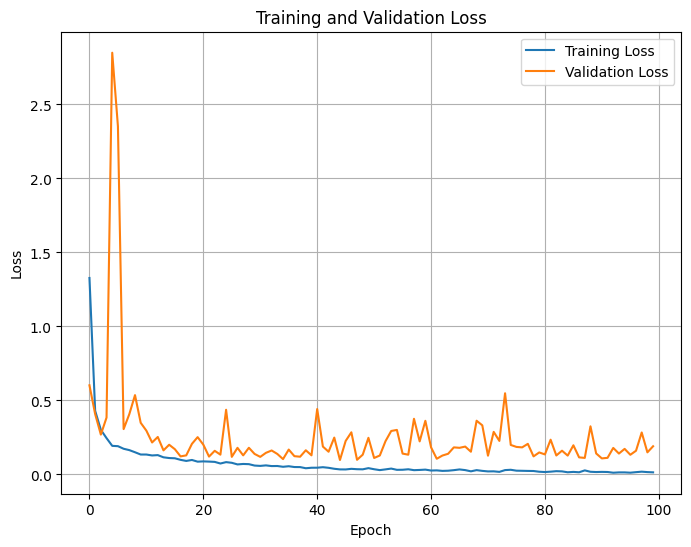

In [143]:
import matplotlib.pyplot as plt

# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Create the plot
plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()

In [144]:
characters

['krusty_the_clown',
 'waylon_smithers',
 'maggie_simpson',
 'barney_gumble',
 'ralph_wiggum',
 'martin_prince',
 'professor_john_frink',
 'rainier_wolfcastle',
 'otto_mann',
 'fat_tony']

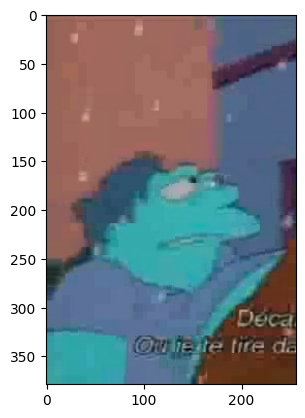

In [145]:
import cv2 as cv
image_path="/kaggle/input/the-simpsons-characters-dataset/simpsons_dataset/barney_gumble/pic_0002.jpg"
img=cv.imread(image_path)
plt.imshow(img,cmap="gray")
plt.show()

In [146]:
def prepare(img):
    img=cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    img=cv.resize(img,IMG_SIZE)
    img=caer.reshape(img,IMG_SIZE,1)
    return img

In [147]:
predictions=model.predict(prepare(img))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 509ms/step


In [148]:
predictions

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [152]:
characters[np.argmax(predictions[0])]

'krusty_the_clown'

In [150]:
predictions

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [151]:
characters

['krusty_the_clown',
 'waylon_smithers',
 'maggie_simpson',
 'barney_gumble',
 'ralph_wiggum',
 'martin_prince',
 'professor_john_frink',
 'rainier_wolfcastle',
 'otto_mann',
 'fat_tony']